In [5]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras import models, optimizers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import cifar10
from PIL import Image
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Activation
from copy import deepcopy

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train / 255.
X_test = X_test / 255.
y_train, y_test = to_categorical(y_train),to_categorical(y_test)
val_split = int(0.8 * X_train.shape[0])
X_train, X_val = X_train[:val_split], X_train[val_split:]
y_train, y_val = y_train[:val_split], y_train[val_split:]

In [3]:
class ConvolutionNet():
    def __init__(self, hidden_units=512,conv_depth=4,dense_depth=1):
        self.hidden_units = hidden_units
        self.conv_depth = conv_depth
        self.dense_depth = dense_depth
    def build_model(self,
                   hidden_act='relu',
                   out_act='softmax',
                   num_filters = 128,
                   optimizer = 'adam',
                   learning_rate=0.001,
                   loss = 'categorical_crossentropy',
                   metrics = ['acc']):
        self.model = models.Sequential()
        self.model.add(layers.Conv2D(num_filters,(3,3),padding='same',input_shape=(32,32,3)))
        self.model.add(BatchNormalization())
        self.model.add(Activation(hidden_act))
        self.model.add(layers.MaxPooling2D((2,2)))
        #self.model.add(layers.Dropout(0.5))
        for i in range(self.conv_depth-1):
            if i == self.conv_depth-2:
                self.model.add(layers.Conv2D(num_filters*2,(3,3),padding='same'))
                self.model.add(BatchNormalization())
                self.model.add(Activation(hidden_act))
                self.model.add(layers.MaxPooling2D((2,2)))
            else:
                self.model.add(layers.Conv2D(num_filters*2,(3,3),activation=hidden_act,padding='same'))
                self.model.add(layers.MaxPooling2D((2,2)))
            #self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Flatten())
#         for _ in range(self.dense_depth):
#             self.model.add(layers.Dense(self.hidden_units,activation=hidden_act))
        self.model.add(layers.Dense(10,activation=tf.nn.softmax))
#         self.model.add(Dense(10))
#         self.model.add(Activation(tf.nn.softmax))
        opt = None
        if optimizer == 'adam':
            opt = optimizers.Adam(lr=learning_rate)
        if optimizer == 'rmsprop':
            opt = optimizers.RMSprop(lr=learning_rate)
        self.model.compile(
                optimizer = opt,
                loss = loss,
                metrics = metrics)
    def fit(self,X,y,hyperparams,**kwargs):
        K.clear_session()
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.25
        sess = tf.Session(config=config)
        set_session(sess)
        if hyperparams:
            self.build_model(**hyperparams)
        else:
            self.build_model()
        self.history = self.model.fit(X,y,**kwargs)

In [4]:
cnn = ConvolutionNet()
hyperparams = dict(optimizer='adam',learning_rate=0.001)
cnn.fit(X_train,
        y_train,
        hyperparams,
        epochs=20,
        batch_size=512,
        validation_data=(X_val,y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 10s 245us/step - loss: 1.7702 - acc: 0.3926 - val_loss: 1.6994 - val_acc: 0.3632
Epoch 2/20
40000/40000 [==============================] - 8s 203us/step - loss: 1.1840 - acc: 0.5806 - val_loss: 2.4682 - val_acc: 0.1965
Epoch 3/20
40000/40000 [==============================] - 8s 201us/step - loss: 0.8997 - acc: 0.6857 - val_loss: 1.5233 - val_acc: 0.4277
Epoch 4/20
40000/40000 [==============================] - 8s 199us/step - loss: 0.7257 - acc: 0.7493 - val_loss: 1.1131 - val_acc: 0.6322
Epoch 5/20
40000/40000 [==============================] - 8s 203us/step - loss: 0.5897 - acc: 0.7973 - val_loss: 1.0427 - val_acc: 0.6427
Epoch 6/20
40000/40000 [==============================] - 8s 201us/step - loss: 0.4749 - acc: 0.8395 - val_loss: 1.1688 - val_acc: 0.6296
Epoch 7/20
40000/40000 [==============================] - 8s 201us/step - loss: 0.3846 - acc: 0.8721 - val_loss: 0.7810 -

In [5]:
hist = cnn.history.history

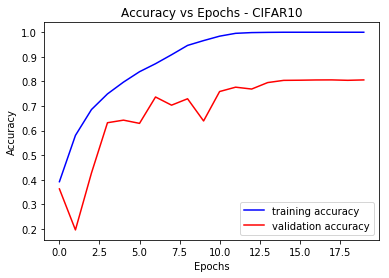

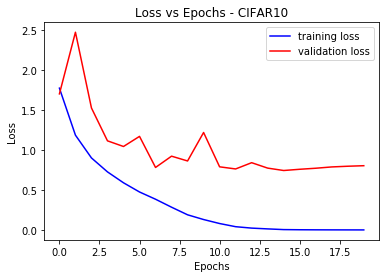

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot()
plt.plot(hist['acc'],'b',label="training accuracy")
plt.plot(hist['val_acc'],'r',label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Epochs - CIFAR10')
plt.legend()
plt.savefig('ques2_acc')

plt.figure()
#plt.plot()
plt.plot(hist['loss'],'b',label="training loss")
plt.plot(hist['val_loss'],'r',label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss vs Epochs - CIFAR10')
plt.legend()
plt.savefig('ques2_loss')

In [7]:
#Inception
from keras.layers import Input, concatenate
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dense
class InceptionConvNet():
    def __init__(self, hidden_units=512,conv_depth=4,dense_depth=1):
        self.hidden_units = hidden_units
        self.conv_depth = conv_depth
        self.dense_depth = dense_depth
    def build_model(self,
                   hidden_act='relu',
                   out_act='softmax',
                   num_filters = 128,
                   optimizer = 'adam',
                   learning_rate=0.001,
                   loss = 'categorical_crossentropy',
                   metrics = ['acc']):
        input_img = Input(shape=(32,32,3))
        #Inception block 1
        i_10 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
        
        i_11 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
        i_11 = Conv2D(32, (3,3), padding='same', activation='relu')(i_11)
        
        i_12 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
        i_12 = Conv2D(32, (5,5), padding='same', activation='relu')(i_12)
        
        i_13 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
        i_13 = Conv2D(32, (1,1), padding='same', activation='relu')(i_13)
        inception_block1 = concatenate([i_10,i_11,i_12,i_13],axis=3)
        
        #Inception block 2:
#         i_20 = Conv2D(64, (1,1), padding='same', activation='relu')(inception_block1)
        
#         i_21 = Conv2D(64, (1,1), padding='same', activation='relu')(inception_block1)
#         i_21 = Conv2D(64, (3,3), padding='same', activation='relu')(i_21)
        
#         i_22 = Conv2D(64, (1,1), padding='same', activation='relu')(inception_block1)
#         i_22 = Conv2D(64, (5,5), padding='same', activation='relu')(i_22)
        
#         i_23 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inception_block1)
#         i_23 = Conv2D(64, (1,1), padding='same', activation='relu')(i_23)
#         inception_block2 = concatenate([i_20,i_21,i_22,i_23],axis=3)
        
        conv_1 = Conv2D(128,(3,3),padding='same')(inception_block1)
        b_1 = BatchNormalization()(conv_1)
        r_1 = Activation(hidden_act)(b_1)
        max_1 = MaxPooling2D((2,2))(r_1)
        conv_2 = Conv2D(256,(3,3),padding='same',activation=hidden_act)(max_1)
        max_2 = MaxPooling2D((2,2))(conv_2)
        conv_3 = Conv2D(256,(3,3),padding='same',activation=hidden_act)(max_2)
        max_3 = MaxPooling2D((2,2))(conv_3)
        conv_4 = Conv2D(256,(3,3),padding='same')(max_3)
        b_4 = BatchNormalization()(conv_4)
        r_4 = Activation(hidden_act)(b_4)
        max_4 = MaxPooling2D((2,2))(r_4)
        
        output = Flatten()(max_4)
        out = Dense(10,activation=tf.nn.softmax)(output)
        
        self.model = Model(inputs=input_img, outputs=out)
        opt = None
        if optimizer == 'adam':
            opt = optimizers.Adam(lr=learning_rate)
        if optimizer == 'rmsprop':
            opt = optimizers.RMSprop(lr=learning_rate)
        self.model.compile(
                optimizer = opt,
                loss = loss,
                metrics = metrics)
    def fit(self,X,y,hyperparams,**kwargs):
        K.clear_session()
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.5
        sess = tf.Session(config=config)
        set_session(sess)
        if hyperparams:
            self.build_model(**hyperparams)
        else:
            self.build_model()
        self.history = self.model.fit(X,y,**kwargs)

In [8]:
in_cnn = InceptionConvNet()
hyperparams = dict(optimizer='adam',learning_rate=0.001)
in_cnn.fit(X_train,
        y_train,
        hyperparams,
        epochs=20,
        batch_size=512,
        validation_data=(X_val,y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 17s 426us/step - loss: 1.7648 - acc: 0.3896 - val_loss: 1.8478 - val_acc: 0.3465
Epoch 2/20
40000/40000 [==============================] - 14s 361us/step - loss: 1.2015 - acc: 0.5708 - val_loss: 1.7382 - val_acc: 0.3802
Epoch 3/20
40000/40000 [==============================] - 15s 364us/step - loss: 0.9300 - acc: 0.6742 - val_loss: 1.6272 - val_acc: 0.4242
Epoch 4/20
40000/40000 [==============================] - 15s 367us/step - loss: 0.7331 - acc: 0.7437 - val_loss: 1.0167 - val_acc: 0.6390
Epoch 5/20
40000/40000 [==============================] - 15s 369us/step - loss: 0.5978 - acc: 0.7938 - val_loss: 0.8430 - val_acc: 0.7066
Epoch 6/20
40000/40000 [==============================] - 15s 372us/step - loss: 0.4737 - acc: 0.8385 - val_loss: 0.7730 - val_acc: 0.7346
Epoch 7/20
40000/40000 [==============================] - 15s 371us/step - loss: 0.3705 - acc: 0.8765 - val_loss: 0.

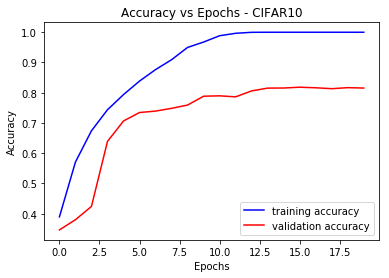

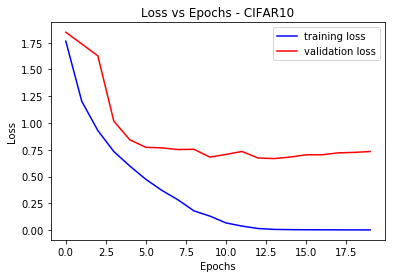

In [9]:
hist = in_cnn.history.history
#plt.plot()
plt.plot(hist['acc'],'b',label="training accuracy")
plt.plot(hist['val_acc'],'r',label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Epochs - CIFAR10')
plt.legend()
plt.savefig('ques2_acc_inception_norm')

plt.figure()
#plt.plot()
plt.plot(hist['loss'],'b',label="training loss")
plt.plot(hist['val_loss'],'r',label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss vs Epochs - CIFAR10')
plt.legend()
plt.savefig('ques2_loss_inception_norm')

In [10]:
#Residual
from keras.layers import Input, concatenate
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dense
from keras import layers
class ResConvNet():
    def __init__(self, hidden_units=512,conv_depth=4,dense_depth=1):
        self.hidden_units = hidden_units
        self.conv_depth = conv_depth
        self.dense_depth = dense_depth
    def build_model(self,
                   hidden_act='relu',
                   out_act='softmax',
                   num_filters = 128,
                   optimizer = 'adam',
                   learning_rate=0.001,
                   loss = 'categorical_crossentropy',
                   metrics = ['acc']):
        input_img = Input(shape=(32,32,3))
        #Residual block
        r_1 = Conv2D(128,(3,3),padding='same')(input_img)
        r_1 = layers.ReLU()(r_1)
        
        r_2 = Conv2D(3,(3,3),padding='same')(r_1)
        
        res_block = layers.add([input_img,r_2])
        res_block = layers.ReLU()(res_block)
        
        conv_1 = Conv2D(128,(3,3),padding='same')(res_block)
        b_1 = BatchNormalization()(conv_1)
        r_1 = Activation(hidden_act)(b_1)
        max_1 = MaxPooling2D((2,2))(r_1)
        conv_2 = Conv2D(256,(3,3),padding='same',activation=hidden_act)(max_1)
        max_2 = MaxPooling2D((2,2))(conv_2)
        conv_3 = Conv2D(256,(3,3),padding='same',activation=hidden_act)(max_2)
        max_3 = MaxPooling2D((2,2))(conv_3)
        conv_4 = Conv2D(256,(3,3),padding='same')(max_3)
        b_4 = BatchNormalization()(conv_4)
        r_4 = Activation(hidden_act)(b_4)
        max_4 = MaxPooling2D((2,2))(r_4)
        
        output = Flatten()(max_4)
        out = Dense(10,activation=tf.nn.softmax)(output)
        
        self.model = Model(inputs=input_img, outputs=out)
        opt = None
        if optimizer == 'adam':
            opt = optimizers.Adam(lr=learning_rate)
        if optimizer == 'rmsprop':
            opt = optimizers.RMSprop(lr=learning_rate)
        self.model.compile(
                optimizer = opt,
                loss = loss,
                metrics = metrics)
    def fit(self,X,y,hyperparams,**kwargs):
        K.clear_session()
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.5
        sess = tf.Session(config=config)
        set_session(sess)
        if hyperparams:
            self.build_model(**hyperparams)
        else:
            self.build_model()
        self.history = self.model.fit(X,y,**kwargs)

In [11]:
res_cnn = ResConvNet()
hyperparams = dict(optimizer='adam',learning_rate=0.001)
res_cnn.fit(X_train,
        y_train,
        hyperparams,
        epochs=20,
        batch_size=512,
        validation_data=(X_val,y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 12s 305us/step - loss: 1.6652 - acc: 0.4189 - val_loss: 2.6092 - val_acc: 0.1751
Epoch 2/20
40000/40000 [==============================] - 11s 276us/step - loss: 1.0741 - acc: 0.6214 - val_loss: 2.0309 - val_acc: 0.2789
Epoch 3/20
40000/40000 [==============================] - 11s 270us/step - loss: 0.7901 - acc: 0.7272 - val_loss: 1.7223 - val_acc: 0.4255
Epoch 4/20
40000/40000 [==============================] - 11s 273us/step - loss: 0.6279 - acc: 0.7849 - val_loss: 1.4880 - val_acc: 0.5067
Epoch 5/20
40000/40000 [==============================] - 11s 270us/step - loss: 0.4943 - acc: 0.8328 - val_loss: 1.0586 - val_acc: 0.6338
Epoch 6/20
40000/40000 [==============================] - 11s 271us/step - loss: 0.3961 - acc: 0.8671 - val_loss: 1.3712 - val_acc: 0.5752
Epoch 7/20
40000/40000 [==============================] - 11s 272us/step - loss: 0.2928 - acc: 0.9051 - val_loss: 0.

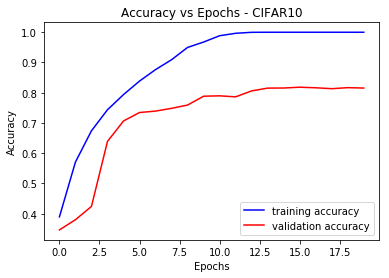

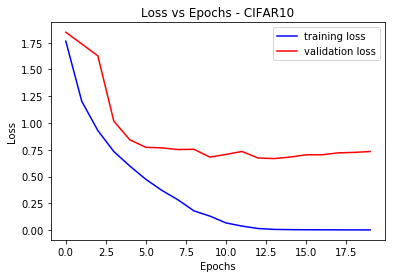

In [12]:
hist = in_cnn.history.history
#plt.plot()
plt.plot(hist['acc'],'b',label="training accuracy")
plt.plot(hist['val_acc'],'r',label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Epochs - CIFAR10')
plt.legend()
plt.savefig('ques2_acc_res_norm')

plt.figure()
#plt.plot()
plt.plot(hist['loss'],'b',label="training loss")
plt.plot(hist['val_loss'],'r',label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss vs Epochs - CIFAR10')
plt.legend()
plt.savefig('ques2_loss_res_norm')